In [1]:
import numpy as np
import networkx as nx
from default_architecture_class import default_arhitecture
from default_architecture_class import arhitecture_specs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from gates import AndGate

In [2]:
lambdas = np.array([3,5,7])
x_values = np.array([0,1,2])

spec = arhitecture_specs(M=3, m0=2, S=3, lambdas=lambdas, x_values=x_values)
arch = default_arhitecture(spec)


def draw_architecture(G, figsize=(14, 6), label_shift=0.25):
    cmap = cm.get_cmap("tab10")
    stages = {}
    for n, data in G.nodes(data=True):
        stage = data.get("stage")
        stages.setdefault(stage, []).append(n)
    stage_order = ["input_code", "logical_weights", "trig", "decoder", "encoder", "output_code", "unknown"]
    stage_order = [s for s in stage_order if s in stages]

    pos = {}
    for x, s in enumerate(stage_order):
        nodes = sorted(stages[s])
        for idx, n in enumerate(nodes):
            pos[n] = (x, -idx)
    
    stage_to_color = {s: i for i, s in enumerate(stage_order)}
    node_colors = [stage_to_color[G.nodes[n].get("stage")] for n in G.nodes()]

    plt.figure(figsize=figsize)

    # edges (with arrows)
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=12,
        width=1.0,
        alpha=0.35,
        connectionstyle="arc3,rad=0.0"
    )

    # nodes
    nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    cmap=cmap,
    vmin=0,
    vmax=max(stage_to_color.values()) if stage_to_color else 1,
    node_size=350,
    linewidths=0.8
)

    labels = {n: n for n in G.nodes()}
    label_pos = {n: (pos[n][0], pos[n][1] - label_shift) for n in G.nodes()}
    nx.draw_networkx_labels(G, label_pos, labels=labels, font_size=7)

    edge_labels = {
            (u, v): data["name"]
            for u, v, data in G.edges(data=True)
            if data.get("name") is not None
        }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    cmap = cm.get_cmap("tab10")
    handles = []

    plt.axis("off")
    plt.tight_layout()
    plt.show()


/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_72808/3544385469.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")
/var/folders/rq/k6q5m5x57ggcclsdrpv0g4j00000gn/T/ipykernel_72808/3544385469.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


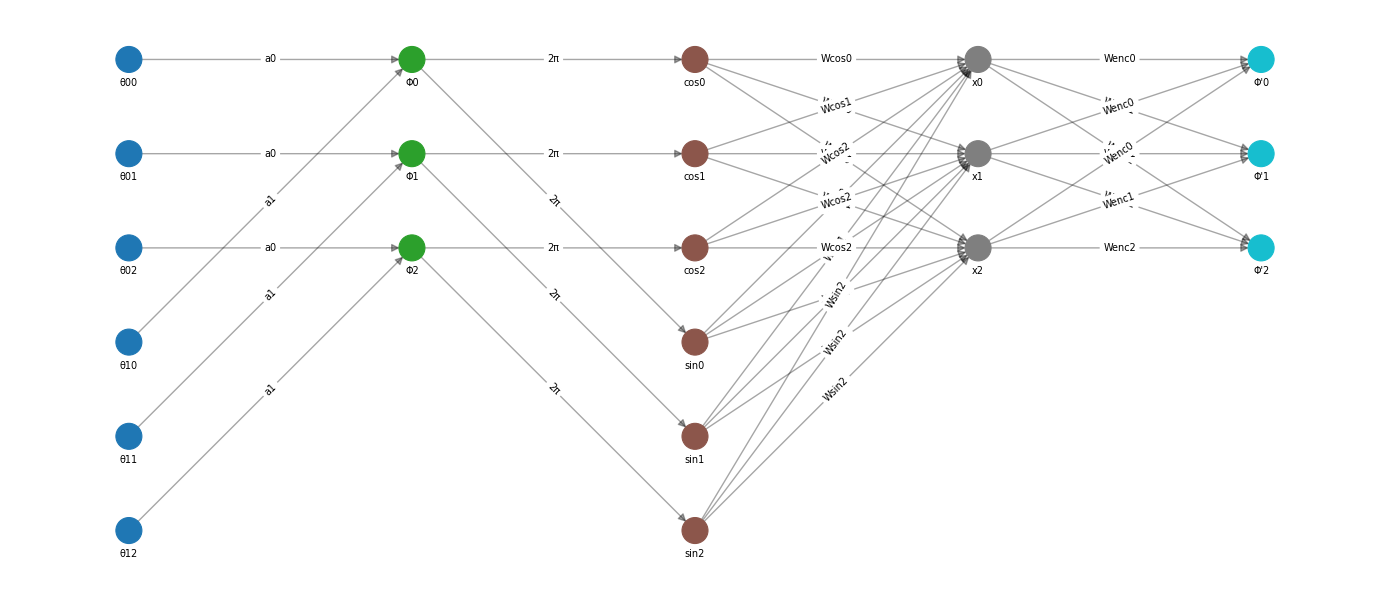

In [ ]:
G = arch.graph()   # or whatever you called it
draw_architecture(G)